### Question 1:
a) Fragment length frequency
We are given a file with each line indicating where a DNA fragment has mapped on the chromosome. Our goal is to count individual fragment lengths, and then normalize it by the total count of all fragment lengths. Once we have the normalized count, we will plot that using plotting packages in python. X-axis will be fragment length (unit - base pairs) and Y-axis-> Normalized frequencies. Fragment length can be simply calculated by subtracting 2nd column from the 3rd.

b) Rescaling
Often, we will receive two sets of data with different empirical distribution. The goal is to rescale one (query) to the other (reference). We are given a reference distribution (reference.hist) and a query bed file (query.bed.gz). We have to rescale (subsample the data) so that when we draw the normalized frequency, it should almost match the reference


In [21]:
import numpy as np
import random
import gzip
import matplotlib.pyplot as plt
from collections import Counter

# Reads a gzipped BED file and calculates fragment lengths
def read_bed(path):
    lens = []
    with gzip.open(path, 'rt') as f:
        for ln in f:
            if ln.startswith('#') or not ln.strip():  # Skip comments and empty lines
                continue
            parts = ln.strip().split('\t')
            s, e = int(parts[1]), int(parts[2])       # Start and end positions
            lens.append(e - s)                        # Fragment length
    return Counter(lens)                              # Count frequency of each length

# Converts raw counts into normalized frequencies (sum to 1)
def normalize(freqs):
    total = sum(freqs.values())
    return {k: v / total for k, v in freqs.items()}

# Reads reference histogram from a tab-separated file
def read_ref(path):
    ref = {}
    with open(path) as f:
        for ln in f:
            if not ln.strip():                        
                continue
            l, f = map(float, ln.strip().split('\t')) # Length and frequency
            ref[int(l)] = f
    return ref

# Scales the query distribution to match the reference frequencies
def scale(query, ref):
    q_norm = normalize(query)
    # Compute keep probability for each length based on reference frequency
    probs = {
        l: min(1.0, ref.get(l, 0) / q_norm[l])
        for l in query if q_norm[l] > 0
    }
    scaled = Counter()
    # Randomly retain fragments with probability proportional to reference
    for l, c in query.items():
        p = probs.get(l, 0)
        kept = sum(random.random() < p for _ in range(c))
        if kept:
            scaled[l] = kept
    return scaled

# Plots original, scaled, and reference fragment length distributions
def plot_dists(orig, scaled, ref):
    plt.figure(figsize=(12, 6))
    all_lens = sorted(set(orig) | set(ref))           # Union of all observed lengths
    f1 = normalize(orig)
    f2 = normalize(scaled)
    c1 = sum(orig.values())
    c2 = sum(scaled.values())
    c3 = sum(ref.values())

    # Plot original distribution
    plt.plot(all_lens, [f1.get(l, 0) for l in all_lens],
             label=f'Original - {c1}', linestyle='--', color='green')

    # Plot rescaled distribution
    plt.plot(all_lens, [f2.get(l, 0) for l in all_lens],
             label=f'Rescaled - {c2}', color='red', marker='*', markersize=6, linewidth=0.8)

    # Plot reference distribution
    plt.plot(all_lens, [ref.get(l, 0) for l in all_lens],
             label='Reference', color='blue', linestyle='--', linewidth=2.5)
    
    plt.xlabel('Fragment Length (bp)')
    plt.ylabel('Normalized Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()


In [22]:
length_freq = import_bed_file('query.bed.gz')
ref_freq = import_reference_histogram('reference.hist')

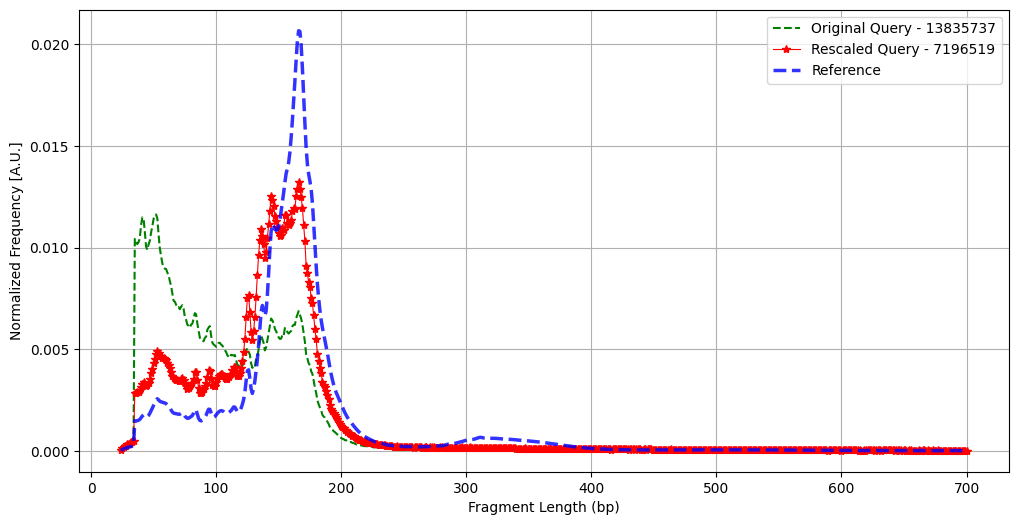

In [23]:
# Main function for execution
if __name__ == "__main__":
    normalized_length_freq = Normalize(length_freq)
    adjusted_counts = rescale(length_freq, ref_freq)
    plot_distributions(length_freq, adjusted_counts, ref_freq)